# Quantum Feature Maps and Kernels

In this section, we will explore quantum feature maps and kernels in detail, before using them in a classification algorithm, introduce kernel alignment and discuss the current state of the art. 

## Introduction

The general task of machine learning is to find and study patterns in data. Many machine learning algorithms map their input dataset to a higher dimensional feature space, through the use of a kernel function: $k(\mathbf{x}_i, \mathbf{x}_j) = \langle f(\mathbf{x}_i), f(\mathbf{x}_j) \rangle$ where $k$ is the kernel function, $\mathbf{x}_i, \mathbf{x}_j$ are $n$ dimensional inputs, $f$ is a map from $n$-dimension to $m$-dimension space and $\langle a,b \rangle$ denotes the dot product. When considering finite data, a kernel function can be represented as a matrix: $K_{ij} = k(\mathbf{x}_i,\mathbf{x}_j)$.

Let's demonstrate the concept of mapping a dataset to a higher dimensional feature space, with the [circles dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), which contains a large circle containing a smaller circle in two dimensions:

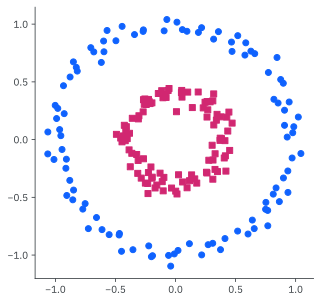

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles

# Create circles dataset
X, Y = make_circles(n_samples=200, noise=0.05, factor=0.4)

# Separate smaller and larger circles
A = X[np.where(Y==0)]
B = X[np.where(Y==1)]

# Plot in 2D
plt.figure(figsize=(5,5))
plt.scatter(A[:,0],A[:,1], marker='o')
plt.scatter(B[:,0],B[:,1], marker='s', c='#D12771')
plt.show()

Looking at the dataset, it's clear there is structure to it, but the two circles are not linearly separable in two dimensions. Let's transform the data into three dimensions, where $z = x^2 + y^2$:

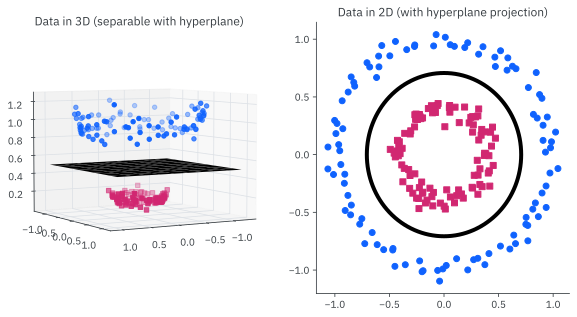

In [2]:
def transform_function(x, y):
    """ Implements f(x,y) = [x, y, z = x^2 + y^2] """
    return np.array([x, y, x**2.0 + y**2.0])

# Transform
A1 = np.array([transform_function(x,y) for 
               x,y in zip(np.ravel(A[:,0]), np.ravel(A[:,1]))])
B1 = np.array([transform_function(x,y) 
               for x,y in zip(np.ravel(B[:,0]), np.ravel(B[:,1]))])

# Plot in 3D
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Data in 3D (separable with hyperplane)")
ax.scatter(A1[:,0], A1[:,1], A1[:,2], marker='o')
ax.scatter(B1[:,0], B1[:,1], B1[:,2], marker='s',
           c='#D12771')  # make red
ax.view_init(5, 60)

x = np.arange(-1.25, 1.25, 0.25)
y = np.arange(-1.25, 1.25, 0.26)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z[:,:] = 0.5
ax.plot_surface(X, Y, Z, color='#010101')

# Project data to 2D
ax2d = fig.add_subplot(122)
ax2d.set_title("Data in 2D (with hyperplane projection)")
ax2d.scatter(A1[:,0], A1[:,1], marker='o')
ax2d.scatter(B1[:,0], B1[:,1], marker='s',
            c='#D12771')  # make red

ax2d.add_patch(pl.Circle((0,0), radius=np.sqrt(0.5),
               fill=False, linestyle='solid', linewidth=4.0,
               color='black'))

plt.show()

As we can see above, in three dimensions, the data is separable by a hyperplane at $z = 0.5$, and if we project the data back to two dimensions, this hyperplane is nonlinear.

## Quantum Feature Maps

In quantum machine learning, a quantum feature map, $\phi(\mathbf{x})$, is used to map a classical feature vector, $\mathbf{x}$, to a quantum Hilbert space, $| \phi(\mathbf{x})\rangle \langle \phi(\mathbf{x})|$. The quantum feature map transforms $\mathbf{x} \rightarrow | \phi(\mathbf{x})\rangle$ using a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$, which is typically a [parameterized quantum circuit](pqc.ipynb).

Constructing quantum feature maps based on parameterized quantum circuits that are hard to simulate classically is an important step towards possibly obtaining an advantage over classical machine learning approaches, and is an active area of current research.


In Reference [1](#References), the authors propose a family of quantum feature maps that are conjectured to be hard to simulate classically and can be implemented as short-depth circuits on near-term quantum devices. These are implemented in Qiskit as the [`PauliFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html). The quantum feature map of depth $d$ is implemented by the unitary operator:
$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$
which contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$, encoding the classical data as shown in circuit diagram below for $d=2$.

![](images/kernel/featuremap.svg)

Within the entangling blocks, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivities between different qubits or datapoints: $S \in \{\binom{n}{k}\ \mathrm{combinations,\ }k = 1,... n \}$, and by default the data mapping function $\phi_S(\mathbf{x})$ is 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

when $k = 2, P_0 = Z, P_1 = ZZ$, this is the [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) in Qiskit: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d$$ 

/usr/local/lib/python3.9/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


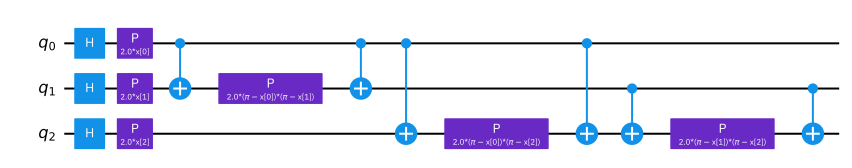

In [3]:
from qiskit.circuit.library import ZZFeatureMap

# 3 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.decompose().draw(style='textbook')

Let's have a look at the [`adhoc`](https://qiskit.org/documentation/stubs/qiskit.ml.datasets.ad_hoc_data.html) dataset in Qiskit, which is a two class dataset sampled from the `ZZFeatureMap` used in Reference [1](#References), creating 20 training datapoints and 5 testing datapoints of 2 features from each class:

In [4]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345

from qiskit_machine_learning.datasets import ad_hoc_data

train_data, train_labels, test_data, test_labels, sample_total = (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, 
                include_sample_total=True, one_hot=False))

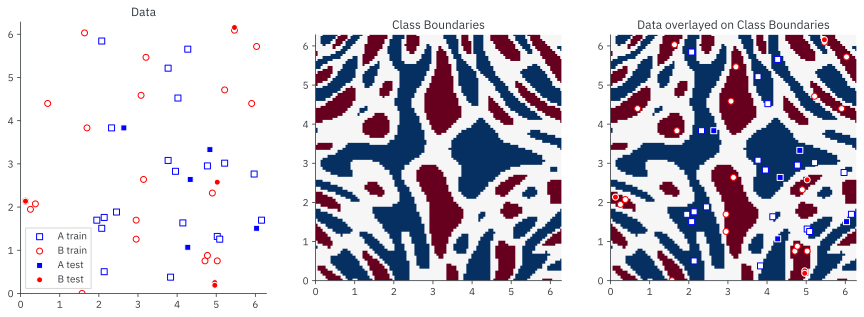

In [5]:
# Plot data and class boundaries
fig = plt.figure(figsize=(15, 5))
axdata = fig.add_subplot(131)
axdata.set_title("Data")
axdata.set_ylim(0, 2 * np.pi)
axdata.set_xlim(0, 2 * np.pi)

plt.scatter(train_data[np.where(train_labels[:] == 0), 0],
            train_data[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='b',
            label="A train")
plt.scatter(train_data[np.where(train_labels[:] == 1), 0],
            train_data[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='r',
            label="B train")
plt.scatter(test_data[np.where(test_labels[:] == 0), 0],
            test_data[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='b', edgecolors='w',
            label="A test")
plt.scatter(test_data[np.where(test_labels[:] == 1), 0],
            test_data[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='r', edgecolors='w',
            label="B test")
plt.legend()

axmap = fig.add_subplot(132)
axmap.set_title("Class Boundaries")
axmap.set_ylim(0, 2 * np.pi)
axmap.set_xlim(0, 2 * np.pi)
axmap.imshow(np.asmatrix(sample_total).T,
             interpolation='nearest',
             origin='lower', cmap='RdBu',
             extent=[0, 2 * np.pi, 0, 2 * np.pi])

axboth = fig.add_subplot(133)
axboth.set_title("Data overlayed on Class Boundaries")
axboth.set_ylim(0, 2 * np.pi)
axboth.set_xlim(0, 2 * np.pi)
axboth.imshow(np.asmatrix(sample_total).T, interpolation='nearest',
              origin='lower', cmap='RdBu',
              extent=[0, 2 * np.pi, 0, 2 * np.pi])
axboth.scatter(train_data[np.where(train_labels[:] == 0), 0],
               train_data[np.where(train_labels[:] == 0), 1],
               marker='s', facecolors='w', edgecolors='b', label="A")
axboth.scatter(train_data[np.where(train_labels[:] == 1), 0],
               train_data[np.where(train_labels[:] == 1), 1],
               marker='o', facecolors='w', edgecolors='r', label="B")
axboth.scatter(test_data[np.where(test_labels[:] == 0), 0],
               test_data[np.where(test_labels[:] == 0), 1],
               marker='s', facecolors='b', edgecolors='w',
               label="A test")
axboth.scatter(test_data[np.where(test_labels[:] == 1), 0],
               test_data[np.where(test_labels[:] == 1), 1],
               marker='o', facecolors='r', edgecolors='w',
               label="B test")

plt.show()

On the left above, we see 25 two-dimensional datapoints from each class in `adhoc` dataset, noting that there is no obvious pattern as to which datapoint belongs to which class. In the middle above, is the two-dimensional projection of the eight-dimensional feature space described by the `ZZFeatureMap` used to create the dataset, noting how complicated the class boundaries are in two dimensions. On the right, we see the datapoints overlayed on the class boundaries. 

## Quantum Kernels

A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close. 

When considering finite data, we can represent the quantum kernel as a matrix: 
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$. We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$
assuming the feature map is a [parameterized quantum circuit](pqc.ipynb), which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on $n$ qubits. 

This provides us with an estimate of the quantum kernel matrix, which we can then use in a kernel machine learning algorithm, such as support vector classification.

Let's analytically calculate and plot the kernel matrix for the training datapoints in the adhoc dataset we created earlier. For the feature map, we will using the [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) for 2 features with 2 repetitions. Note that the `calculate_kernel` function here is a simpler version of the `evaluate` function in the Qiskit [`QuantumKernel`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.html) class.

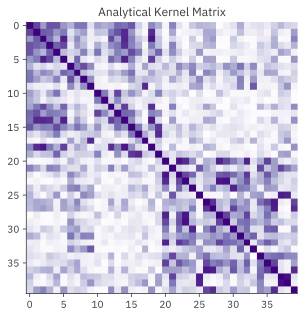

In [17]:
import qiskit.opflow as opflow

def calculate_kernel(feature_map, x_data, y_data=None):
    """ 
        Calculates  kernel matrix from provided feature map and
        dataset(s), x & (y). If y isn't given, self inner product
        of x is calculated. 
        
        No error checking is performed, feature map and datasets
        assumed to have the same dimension
    """

    if y_data is None:
        y_data = x_data

    # Use Operator Flow to create a list of feature map circuits,
    # parameterized by each datapoint
    x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        {param:vals for (param, vals) in zip(feature_map.parameters, 
                                         np.transpose(x_data).tolist())})

    y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        {param:vals for (param, vals) in zip(feature_map.parameters, 
                                         np.transpose(y_data).tolist())})

    # Compute the square of the conjugate inner product of the feature
    # map circuits: the kernel matrix
    kernel = np.abs(
        (~y_circuits.to_matrix_op() @ x_circuits.to_matrix_op()).eval()
    )**2
    
    return kernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

kernel = calculate_kernel(adhoc_feature_map, train_data)

plt.figure(figsize=(5, 5))
plt.imshow(np.asmatrix(kernel),interpolation='nearest', origin='upper')
plt.title("Analytical Kernel Matrix")
plt.show()

A few things to note about the kernel matrix:

1. Each row / column represents the transition amplitute of a single datapoint, with all other datapoints in the dataset
2. The transition amplitute of a datapoint with itself is 1, so the matrix has a unit diagonal
3. The matrix is symmetric, the transition amplitude of $x \rightarrow y$ is the same as $y \rightarrow x$. 

## Quantum Support Vector Classification

As mentioned at the start of this section, many machine learning algorithms use kernels functions to map their input dataset to a higher dimensional feature space. The well known support vector machine classification algorithm is one of these.  For more information about the support vector classification algorithm, see the `scikit-learn` [User Guide](https://scikit-learn.org/stable/modules/svm.html).

A support vector machine constructs a hyperplane in feature space, which can then be used for classification, regression or other tasks. For classification, the hyperplane ideally has the largest distance to the nearest training datapoints for any class. The figure below shows the decision function for a linearly separable problem, with three samples on the class boundaries, called “*support vectors*”:
<div><img src="images/svm.png" width="" /></div>

Introduced in References [1](#References) and [2](#References), the quantum kernel support vector classification algorithm consists of these steps:

![](images/kernel/qsvc.svg)

1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_i}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

Let's execute the quantum kernel support vector classification algorithm  on the adhoc dataset we generated earlier. Recall that this dataset was created from the `ZZFeatureMap` with `depth = 2` and `dimension = 2`, and consisted of 2 classes, with 20 training and 5 testing datapoints from each class. 

First, let's calculate the training and testing quantum kernel matrices using the `calculate_kernel` function we wrote earlier:

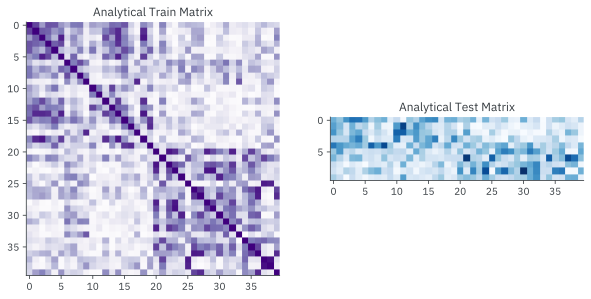

In [10]:
train_kernel = calculate_kernel(adhoc_feature_map, train_data)
test_kernel = calculate_kernel(adhoc_feature_map, train_data, test_data)

# plot analytical matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest',
              origin='upper')
axs[0].set_title("Analytical Train Matrix")
axs[1].imshow(np.asmatrix(test_kernel), interpolation='nearest',
              origin='upper', cmap='Blues')
axs[1].set_title("Analytical Test Matrix")
plt.show()

Now let's use them in the `scikit-learn` `svc` algorithm:

In [11]:
from sklearn.svm import SVC

# train scikit-learn svm model
model = SVC(kernel='precomputed')
model.fit(train_kernel, train_labels)

print("Number of support vectors for each class:",model.n_support_)
print("Indices of support vectors:", model.support_)

Number of support vectors for each class: [ 9 10]
Indices of support vectors: [ 3  6  7  8  9 11 12 17 19 21 22 24 25 26 27 31 33 38 39]


Recall that a support vector machine constructs a hyperplane in feature space, and for classification, the hyperplane ideally has the largest distance to the nearest training datapoints for any class. The nearest training datapoints to the seperating hyperplan in each class are called “support vectors”.

So here the `scikit-learn` `svc` algorithm has identified 9 support vectors for the first class, and 10 support vectors for the second class, out of the training dataset, which had 20 data points from each class.

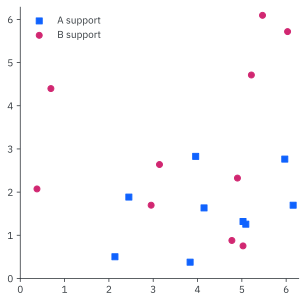

In [13]:
# Plot support vectors
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)

plt.scatter(train_data[model.support_[0:model.n_support_[0]], 0],
            train_data[model.support_[0:model.n_support_[0]], 1],
            marker='s', label="A support")
plt.scatter(train_data[model.support_[model.n_support_[0]:], 0],
            train_data[model.support_[model.n_support_[0]:], 1],
            marker='o', c='#D12771', label="B support")
plt.legend(loc='upper left', frameon=False)
plt.show()

In [14]:
# test svm model
model.score(test_kernel, test_labels)

1.0

We see that since the training and testing datapoints were generated using the same feature map used in the quantum kernel support vector classification algorithm, we are able to classify the testing datapoints perfectly. This will possibly not be the case using hardware due to noise, and probably not be the case for a real world dataset. 

### *Qiskit Implementation*

Qiskit contains a [`QuantumKernel`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.html) class, which can be used directly in the `scikit-learn` `svc` algorithm. Here is a how to use that class with the same dataset.

In [15]:
from qiskit import BasicAer
from qiskit_machine_learning.kernels import QuantumKernel

# Create the quantum feature map
adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')
# Create the quantum kernel
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))

# Set the SVC algorithm to use our custom kernel
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(train_data, train_labels)
adhoc_svc.score(test_data, test_labels)

1.0

## Quantum Kernel Alignment

All of the feature map (data encoding) circuits we have seen so far have not contained any trainable parameters - all the parameters in the circuits are defined by the data being encoded. Quantum feature maps can have variational parameters, that can be optimized using a technique called kernel alignment, as discussed in References [3](#References) and [4](#References), and described in the [Quantum Kernel Alignment with Qiskit Runtime Tutorial](https://qiskit.org/documentation/partners/qiskit_runtime/tutorials/qka.html). This is analogous to kernel alignment in [classical machine learning](https://link.springer.com/article/10.1007%2Fs10462-012-9369-4).

## Quantum Kernel Machine Learning

As we have seen, quantum kernel methods provide a way to use a quantum processer in machine learning. The most prevelant quantum kernel algorithm is the quantum kernel support vector machine (QKSVM) introduced by References [1](#References) and [2](#References) in 2019, which since has been studied in detail. Notably:

- In Reference [1](#References), kernel based training is shown to find better or equally good quantum models than variational circuit training, using less quantum processing.
- In Reference [5](#References), QKSVM is proven to provide a speed up over classical methods for certain specific input data classes. 
- In Reference [6](#References), QKSVM is used to quantify the computational power of data in quantum machine learning algorithms and understand the conditions under which quantum models will be capable of outperforming classical ones.

Quantum kernels can also be used for other machine learning tasks, not just classification. For an example of clustering using a quantum kernel, see the [Qiskit Quantum Kernel Machine Learning Tutorial](https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html).

## References

1. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1804.11326](https://arxiv.org/abs/1804.11326).
1. Maria Schuld and Nathan Killoran, *Quantum machine learning in feature Hilbert spaces*, Phys. Rev. Lett. 122, 040504 (2019), [doi.org:10.1103/PhysRevLett.122.040504](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.040504), [arXiv:1803.07128](https://arxiv.org/abs/1803.07128).
1. Jennifer R. Glick, Tanvi P. Gujarati, Antonio D. Corcoles, Youngseok Kim, Abhinav Kandala, Jay M. Gambetta and Kristan Temme, *Covariant quantum kernels for data with group structure*, [arXiv:2105.03406](https://arxiv.org/abs/2105.03406)
1. Thomas Hubregtsen, David Wierichs, Elies Gil-Fuster, Peter-Jan H. S. Derks, Paul K. Faehrmann and Johannes Jakob Meyer, *Training Quantum Embedding Kernels on Near-Term Quantum Computers*, [arXiv:2105.02276](https://arxiv.org/abs/2105.02276)
1. Yunchao Liu, Srinivasan Arunachalam and Kristan Temme, *A rigorous and robust quantum speed-up in supervised machine learning* (2020), [arXiv:2010.02174](https://arxiv.org/abs/2010.02174).
1. Hsin-Yuan Huang, Michael Broughton, Masoud Mohseni, Ryan Babbush, Sergio Boixo, Hartmut Neven and Jarrod R. McClean, *Power of data in quantum machine learning* (2020), [arXiv:2011.01938](https://arxiv.org/abs/2011.01938).


In [16]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
